<a href="https://colab.research.google.com/github/JiayuShen0912/Week4-Neural_Network/blob/Jiayu_Shen/Jiayu_Shen_Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


At first, I import the required libraries.

In [11]:
#importing the required libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')


 I will apply neural network algorithms to my combined dataset and to analyze how these models perform in comparison to the classical machine learning models previously used (as done in the tutorial). I will focus on understanding the differences in performance, accuracy, and computational efficiency between neural networks and classical approaches, and provide insights into why these differences occur.

# Feature Extraction

The tutorial in Week 4 make full use of librosa, a Python library that supports audio analysis and feature extraction. Librosa abstracts away all the math and most of the details of mel spectrorgams, chromagrams, and MFCC. And the Mel Spectrogram, MFCC, and chromagrams of each audio file are taken as separate features to try and have bit more discriminatory power between samples.

As in the tutorial, I will build feature extraction functions to get a chromagram, a mel spectorgram, and MFC coefficients for each of audio files in merged RAVDESS dataset. Because the chromagram, mel spectrogram and MFCCs are calculated on audio frames produced by STFT, I’m going to get a matrix back from each function, so I’ll take the mean of those matrices to produce a single feature array for each feature and each audio sample, i.e. 3 feature arrays per audio sample.

**Chromagram**: Will produce 12 features; One for each of 12 pitch classes

**Mel Spectrogram**: Will produce 128 features; We've defined the number of mel frequency bands at n_mels=128

**MFCC**: Will produce 40 MFCCs; I've set the number of coefficients to return at n_mfcc=40

In [12]:
def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfc_coefficients

In [13]:
def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

## Load the Dataset and Compute Features

In [14]:
#Emotions in the merged RAVDESS dataset
emotions ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

Load entire merged RAVDESS dataset and compute the features of each audio file:

In [15]:
import os, glob

def load_data():
    X,y=[],[]
    count = 0
    for file in glob.glob("/content/drive/MyDrive/IAT481/RAVDESS/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        features = get_features(file)
        X.append(features)
        y.append(emotion)
        count += 1
        # '\r' + end='' results in printing over same line
        print('\r' + f' Processed {count}/{1510} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

Compute the feature matrix and read the emotion labels for the entire dataset. The regressor (independent/explanatory variable), usually denoted X, is named 'features', andnthe regressand (dependent variable), usually denoted y, is named 'emotions'.

In [16]:
features, emotions = load_data()

 Processed 1508/1510 audio samples 

Let's see what the features we extracted look like, **also for saving both the features matrix as well as emotions array, we need to convert them to pandas dataframe.**

In [17]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display


#making dataframe for emotions as well
emotions_df = pd.DataFrame(emotions) # make it pretty for display

features_df


Audio samples represented: 1508
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.569650,0.511629,0.486809,0.499304,0.554209,0.610285,0.588292,0.531206,0.522197,0.537568,...,-3.489179,-1.955379,0.638049,2.035588,3.051776,1.285880,0.777809,0.298674,1.088430,1.947831
1,0.591314,0.580532,0.544023,0.531094,0.536080,0.575465,0.563722,0.523559,0.522148,0.511368,...,2.640258,3.105846,2.087801,0.757197,-0.722070,-0.954847,-0.521858,1.165337,-0.001878,0.699785
2,0.579503,0.611874,0.588196,0.587334,0.606275,0.636838,0.655012,0.608979,0.582320,0.543539,...,0.903171,1.931618,0.779822,-0.643997,-1.121696,-1.498739,-2.400375,1.035164,0.205413,1.030541
3,0.562346,0.544891,0.542194,0.536488,0.573897,0.609642,0.609065,0.627652,0.588858,0.542940,...,1.690105,2.177219,0.108222,-1.828352,-1.463905,-1.643703,-1.864349,-0.043300,-0.512388,0.247394
4,0.534473,0.508660,0.492394,0.499844,0.566009,0.615148,0.588253,0.564149,0.575790,0.536559,...,0.543994,1.823261,1.121093,0.685013,0.182141,-0.984069,-1.995980,-0.824483,-1.031853,0.427088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.512651,0.486514,0.461302,0.508587,0.560068,0.484810,0.444028,0.457924,0.553169,0.573116,...,5.759862,6.355183,-1.343105,3.267918,2.497807,5.027735,2.651696,5.945119,0.777430,1.573013
1504,0.671552,0.672361,0.721524,0.796471,0.820246,0.800492,0.718540,0.665389,0.675278,0.671041,...,0.501173,0.750682,1.155867,2.139405,2.853925,4.503896,4.369723,5.673851,3.814040,3.972134
1505,0.465606,0.412895,0.470289,0.543011,0.545508,0.543211,0.522468,0.606573,0.639784,0.545700,...,7.082126,6.705487,2.212560,2.411969,0.835325,3.989799,3.049524,2.829816,-1.029237,1.390248
1506,0.495226,0.458357,0.447500,0.480542,0.480229,0.532152,0.600867,0.531699,0.533897,0.568107,...,5.743649,5.726628,3.702856,6.953134,3.173564,4.104837,1.698271,-0.328703,-4.103455,-0.273011


I have a matrix of dim 1508 x 180. 1508 audio samples, one per row, with a series of 180 numerical features for each sample.
Each of the 1508 feature arrays has 180 features composed of 12 chromagram pitch classes + 128 mel spectrogram bands + 40 MFC coefficients.

Now I will save our features matrix and emotions array in excel file I dont have to compute them everytime I run the notebook, I can just load them from the excel file whenever required.

In [18]:
features_df.to_excel('/content/drive/MyDrive/IAT481/featuresRavdess.xlsx')
emotions_df.to_excel('/content/drive/MyDrive/IAT481/emotionsRavdess.xlsx')

# Load pre-saved Dataset

Once saved I only need to load them later by running the cell below, and skip every cell above except for the one in which I import libraries.

In [19]:
features=pd.read_excel('/content/drive/MyDrive/IAT481/featuresRavdess.xlsx',index_col=0)
emotions=pd.read_excel('/content/drive/MyDrive/IAT481/emotionsRavdess.xlsx',index_col=0)

Let's see if they have been loaded correctly!

In [20]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.569650,0.511629,0.486809,0.499304,0.554209,0.610285,0.588292,0.531206,0.522197,0.537568,...,-3.489179,-1.955379,0.638049,2.035588,3.051776,1.285880,0.777809,0.298674,1.088430,1.947831
1,0.591314,0.580532,0.544023,0.531094,0.536080,0.575465,0.563722,0.523559,0.522148,0.511368,...,2.640258,3.105846,2.087801,0.757197,-0.722070,-0.954847,-0.521858,1.165337,-0.001878,0.699785
2,0.579503,0.611874,0.588196,0.587334,0.606275,0.636838,0.655012,0.608979,0.582320,0.543539,...,0.903171,1.931618,0.779822,-0.643997,-1.121696,-1.498739,-2.400375,1.035164,0.205413,1.030541
3,0.562346,0.544891,0.542194,0.536488,0.573897,0.609642,0.609065,0.627652,0.588858,0.542940,...,1.690105,2.177219,0.108222,-1.828352,-1.463905,-1.643703,-1.864349,-0.043300,-0.512388,0.247394
4,0.534473,0.508660,0.492394,0.499844,0.566009,0.615148,0.588253,0.564149,0.575790,0.536559,...,0.543994,1.823261,1.121093,0.685013,0.182141,-0.984069,-1.995980,-0.824483,-1.031853,0.427088


In [21]:
emotions

,0
0,neutral
1,happy
2,sad
3,fearful
4,fearful
...,...
1503,happy
1504,sad
1505,happy
1506,happy


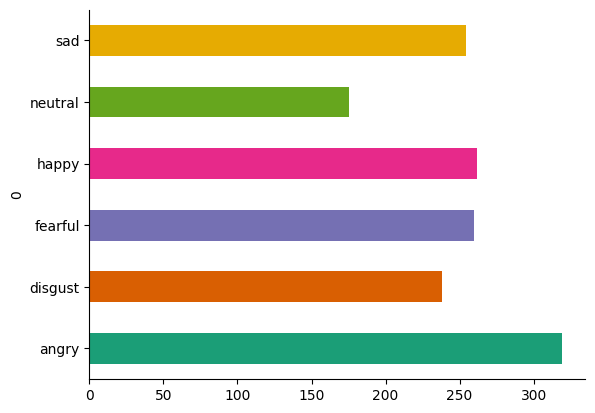

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns
emotions.groupby(0).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Let's see what the features I extracted look like:

In [23]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display
labels_df=pd.DataFrame(emotions)


Audio samples represented: 1508
Numerical features extracted per sample: 180


I have a matrix of dim 1508 x 180. 1508 audio samples, one per row, with a series of 180 numerical features for each sample.
**Each of the 1508 feature arrays has 180 features composed of 12 chromagram pitch classes + 128 mel spectrogram bands + 40 MFC coefficients.**

Let's see the class balance of merged RAVDESS dataset:

['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad'] [319 238 260 262 175 254]


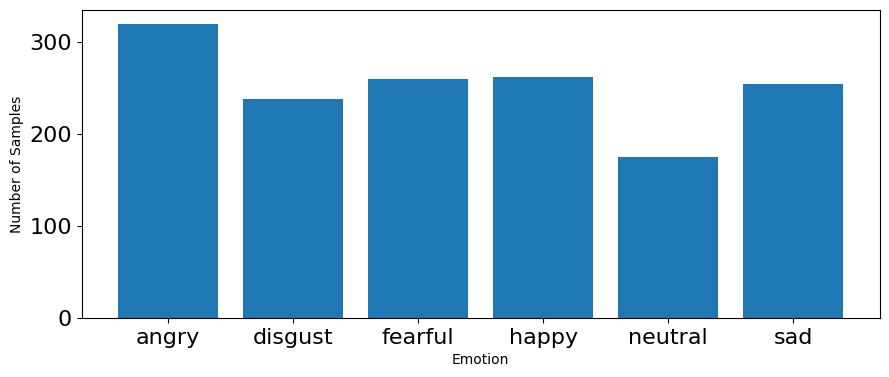

In [24]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotions, return_counts=True)
print(emotion_list,count)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

The classes don't look balanced. This makes the task not so easy. The emotion of anger has a "strong" intensity, but the amount of neutral samples is small, and the amount of other emotions is more balanced.

## Feature Scaling

To properly perform audio data classification utilizing different machine learning models, I first need to scale features. **This is crucial for models which compute distances between data, and especially critical for DNNs**: If there is a difference in the variance of features simply because of their possible range of values, then a model will learn that the features with the greatest variance are the most important.  However, **differences in the variance of unscaled features belonging to different and unknown distributions is an inappropriate measure of importance**.  Let's check features' properties:

In [25]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}')

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

print_features(features_df)

12 Chromagram features:           min = 0.276,     max = 0.888,     mean = 0.640,     deviation = 0.093

128 Mel Spectrogram features:     min = 0.000,     max = 886.647,     mean = 1.328,     deviation = 9.748

40 MFCC features:                 min = -863.639,    max = 121.174,    mean = -11.163,    deviation = 82.575



To properly perform audio data classification utilizing different machine learning models, I first need to scale features. As in the tutorial, I chose sklearn’s StandardScaler and MinMaxScaler to scale the features of the combined RAVDESS dataset. Standard scaling subtracts the mean of each feature and then divides by the standard deviation of that feature to get a mean of 0 and the features of the unit variance, i.e. the variance and standard deviation, of 1. Min-Max scaling converts each feature into a specified bounded interval.

In practice, minimum scaling is particularly useful when it is known that the feature should be within a bounded interval, such as the pixel values in [0,255], while standard scaling may be more practical for features with unknown distributions, because concentrating the feature at zero mean with a standard deviation of 1 means that the extreme value will have a smaller impact on the model's learning weight, i.e. the model is less sensitive to outliers.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

Make sure features are properly scaled:

In [27]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -4.045,     max = 2.601,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.475,     max = 33.092,     mean = -0.000,     deviation = 1.000

40 MFCC features:                 min = -4.719,    max = 6.582,    mean = 0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.599,     deviation = 0.179

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.024,     deviation = 0.068

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.393,    deviation = 0.177


Zero mean and unit variance for standard scaling and in the range [0,1] for MinMax scaling - a default when we don't specify values. We can now move on to building predictive models for these features.

# The MLP Model for Classification

As in the tutorial, I'm going to first try a Multilayer Perceptron (MLP) Classifier, a simple artificial neural network (ANN) model well-suited for predictions trained on labelled inputs.

This assignment is designed for us to apply neural network algorithms to our combined dataset and to analyze how these models perform in comparison to the classical machine learning models previously used. In order to compare models, I'll have to evaluate their performance.  

## Training: The 80/20 Split and Validation

The simplest method to do so is to train a model on a portion of my dataset and test it on the remainder. I'll use sklearn's train_test_split to create a standard 80/20 train/test split. The model is fit on 80% of the data and tested for performance against 20% of the data, which it has never seen in training - also called the hold-out set.

Different set ratios are used in this approach. For simplicity, I'm going to start with an 80/20 train/test split.  The model will be trained on all the training data, and I will check its performance on the test data.  Define unscaled and scaled training and test sets:

In [28]:
from sklearn.model_selection import train_test_split
############# Unscaled test/train set #############
X_train, X_test, y_train, y_test = train_test_split(
    features,
    emotions,
    test_size=0.2,
    random_state=69
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

## MLP Initialization

As done in tutorial, I initialized an MLP classification model with random weights and biases at zero, the standard modality. There are techniques for determining optimal weight initialization; the initial distribution of weights is incrediby important because they impact the direction of the gradient and will determine how fast and whether at all a model's loss function will converge.

I'll try the off-the-shelf MLP model that comes with sklearn. Using default settings for neural networks is not a good idea in general - and **checking a model's performance on test data before tuning the model on a validation set is incorrect methodology**... but for demonstrative purposes:

In [29]:
from sklearn.neural_network import MLPClassifier

# Default 'off-the-shelf' MLP from sklearn
model = MLPClassifier(
    random_state = 69
)

#################### unscaled features #####################
X_train, X_test, y_train, y_test = train_test_split(
    features,
    emotions,
    test_size=0.2,
    random_state=69
)

model.fit(X_train, y_train)

print(f'Possible emotions predicted by model:{model.classes_}')
print(f'Unscaled MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Unscaled MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Possible emotions predicted by model:['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
Unscaled MLP Model's accuracy on training set is 67.58%
Unscaled MLP Model's accuracy on test set is 50.00%


However, I expected the model to have poor performance without thought given to the model or feature scale. But from the results I got, the model's possible prediction of emotion classification is correct, and it is even doing a little better than guessing with a 1/8 (12.5%) chance. The model yielded more results than I expected.

Let's see how feature scaling impacts the performance of the MLP:

In [30]:
#################### minmax scaled #######################
# Rebuild the training set from the minmax scaled features
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_minmax,
    emotions,
    test_size=0.2,
    random_state=69
)

# Fit the model again on the minmax scaled features
model.fit(X_train_minmax, y_train)

print(f'MinMax scaled MLP Model\'s accuracy on training set is {100*model.score(X_train_minmax, y_train):.2f}%')
print(f'MinMax sacled MLP Model\'s accuracy on test set is {100*model.score(X_test_minmax, y_test):.2f}%\n')

#################### standard scaled #######################
# Rebuild the training set from the standard scaled features
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)
# Fit the model again on the scaled features
model.fit(X_train_scaled, y_train)

print(f'Standard scaled MLP Model\'s accuracy on training set is {100*model.score(X_train_scaled, y_train):.2f}%')
print(f'Standard scaled MLP Model\'s accuracy on test set is {100*model.score(X_test_scaled, y_test):.2f}%')

MinMax scaled MLP Model's accuracy on training set is 62.19%
MinMax sacled MLP Model's accuracy on test set is 50.00%

Standard scaled MLP Model's accuracy on training set is 92.54%
Standard scaled MLP Model's accuracy on test set is 61.92%


Standard scaling is indeed the way to go here. It is important to consider choice of scaling method, if necessary, as a crucial hyperparameter of a model. Skipping this step or choosing the wrong scaling method can render even the most appropriate features, worthless.

Perhaps with some effort I can make the MLP model work for me.

## Choice of Hyperparameters

Now that I has already known standard scaling is best for my features, I'll use those for our training and test sets. I will initialize the MLP Classifier and choose parameters I want to keep constant and choose the grid of hyperparameters I want to use for Grid Search to build my candidate models. I will create a grid search object which will store the scores and hyperparameters of all candidate models and fitted the models specified by the parameter grid to get the best hyperparameters from grid search object with its best_params_ attribute.

In [ ]:
from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend


# Now that we know standard scaling is best for our features, we'll use those for our training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

# Initialize the MLP Classifier and choose parameters we want to keep constant
model = MLPClassifier(
    # tune batch size later
    batch_size=256,
    # keep random state constant to accurately compare subsequent models
    random_state=69
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
parameter_space = {
    # A single hidden layer of size between 8 (output classes) and 180 (input features) neurons is most probable
    # It's a bad idea at guessing the number of hidden layers to have
    # ...but we'll give 2 and 3 hidden layers a shot to reaffirm our suspicions that 1 is best
    'hidden_layer_sizes': [(180,), (300,),(100,50,)],
    'activation': ['relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01],
    #'epsilon': [1e-08, 0.1],
    'learning_rate': ['adaptive', 'constant']
}

# Create a grid search object which will store the scores and hyperparameters of all candidate models
grid = GridSearchCV(
    model,
    parameter_space,
    cv=10,
    n_jobs=-1,
    verbose=10)
# Fit the models specified by the parameter grid
with parallel_backend('multiprocessing'):
    grid.fit(X_train, y_train)


# get the best hyperparameters from grid search object with its best_params_ attribute
print('Best parameters found:\n', grid.best_params_)

[CV 2/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd[CV 1/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV 2/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.587 total time=   7.7s
[CV 3/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 1/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.512 total time=   7.9s
[CV 4/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 3/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.579 total time=   8.7s
[CV 5/10; 1/48] START activation=relu, alpha=0

# Training and Evaluating the MLP Model

In [32]:
# declare again so I don't have to re-run gridsearch when I restart the jupyter kernel
# our default X_train, X_test are now standard scaled features since we know they're best
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

model = MLPClassifier(
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=256,
    hidden_layer_sizes=(300,),
    learning_rate='adaptive',
    max_iter=1000, # I've found for this task, loss converges at ~1000 iterations
    random_state=69,
)

model.fit(X_train, y_train)

print(f'MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

MLP Model's accuracy on training set is 100.00%
MLP Model's accuracy on test set is 70.20%


I got slightly better results, but not great, which is to be expected, as most of the hyperparameters selected for grid search are the default values for sklearn’s MLP. In any case, the MLP model overfits the training data and does not generalize well to the test set. Despite the near-perfect training accuracy, it is clear that the loss function of my model is convergent.

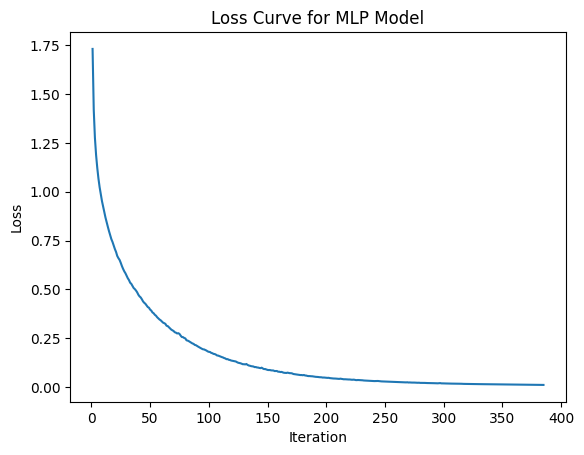

In [33]:
plt.figure()
plt.plot([num for num in range(1,model.n_iter_ +1)], model.loss_curve_)
plt.title('Loss Curve for MLP Model')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

## The Confusion Matrix

I used the confusion matrix to check where my model messed up, i.e., made a wrong prediction. The axis of the matrix is labeled with all possible categories, with vertical levels/columns representing predicted categories and horizontal levels/rows representing basic facts. The intersection of emotions on the diagonal of the matrix is the label of correct prediction. All non-diagonal elements are incorrect predictions.

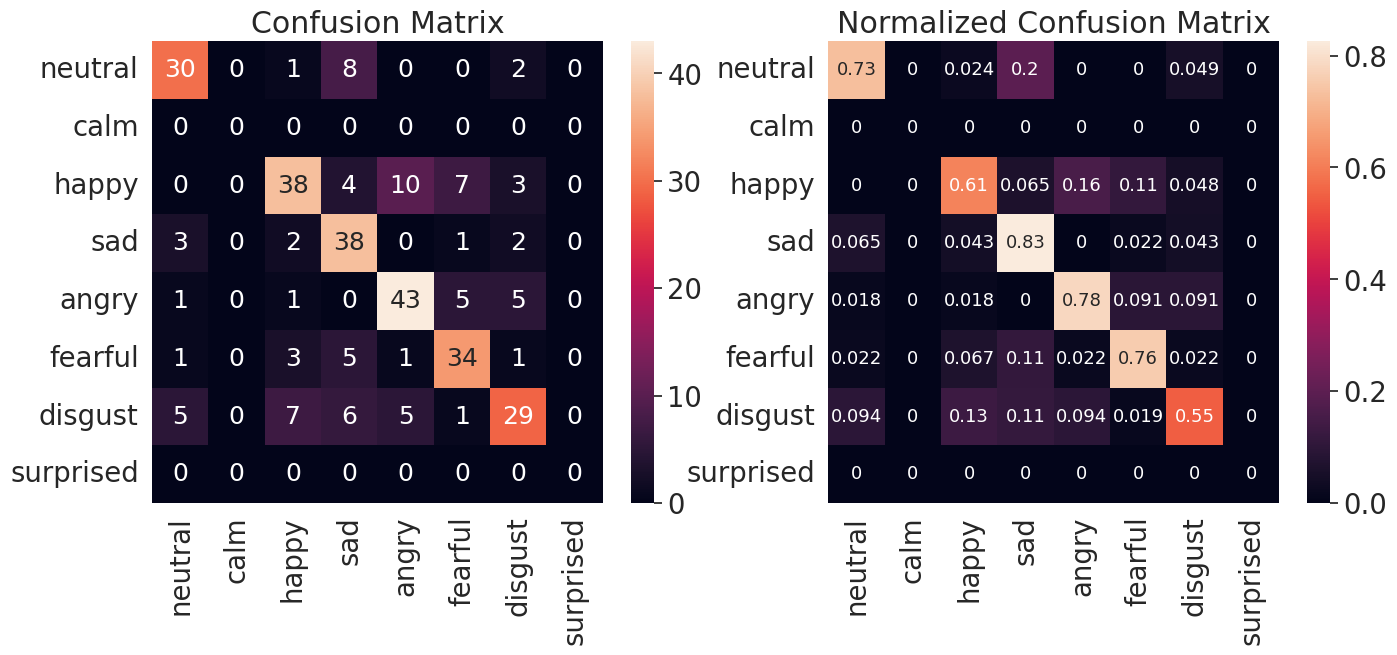

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sn # I like seaborn's confusion matrix over sklearn's default

# get predictions on test set
test_emotion_predictions = model.predict(X_test)
test_emotion_groundtruth = y_test

# set labels for matrix axes from emotions
emotion_list =['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
emotion_name = [emotion for emotion in emotion_list]

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions, labels=emotion_list)
conf_matrix_norm = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions,normalize='true', labels=emotion_list)



# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_name, columns=emotion_name)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_name, columns=emotion_name)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

I can tell the model is most accurate at predicting ‘sad’, and least accurate at predicting ‘disgust’.

## Precision, Recall, F-Score

Precision is a measure of how many positive predictions are true positives, and recall is a measure of how many positives we actually predicted from all positive samples in the dataset: Lower precision means we have more false positives, while lower recall means we have more false negatives.  For this dataset, precision of each emotion is how often we correctly predict it and recall is how many of that emotion I predicted out of all samples with that emotion in the dataset.

In [35]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
print(f'Test Set Accuracy score =  {100*accuracy_score(y_test, y_pred):.3f}%') #same as model.score(X_test, y_test)
print(f'Test Set Precision score =  {100*precision_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set Recall score =  {100*recall_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set F-score score =  {100*f1_score(y_test, y_pred, average="macro"):.3}%')

Test Set Accuracy score =  70.199%
Test Set Precision score =  70.522%
Test Set Recall score =  70.921%
Test Set F-score score =  70.2%


We can see from the results in the image below that they are very balanced overall - with roughly the same false positive and false negative rates.

## K-Fold Cross-Validation

In [36]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(
    n_splits=10,
    random_state=69,
    shuffle=True
)

scores = []
X_train=pd.DataFrame(X_train)
y_train=pd.DataFrame(y_train)
for train_indices, test_indices in kfold.split(X_train,y_train):



    train_x=X_train.iloc[train_indices]
    train_y=y_train.iloc[train_indices]

    test_x=X_train.iloc[test_indices]
    test_y=y_train.iloc[test_indices]
    # fit model to training fold
    model.fit(train_x, train_y)
    # score the model on validation fold
    scores.append(model.score(test_x, test_y))

print('KFold CV scores for MLP:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for MLP: {100*np.mean(scores):.2f}% ± {100*np.std(scores):.2f}%')

KFold CV scores for MLP:
70.25%
72.73%
64.46%
72.73%
65.29%
66.12%
75.00%
74.17%
74.17%
71.67%
Mean score of KFold CV for MLP: 70.66% ± 3.76%


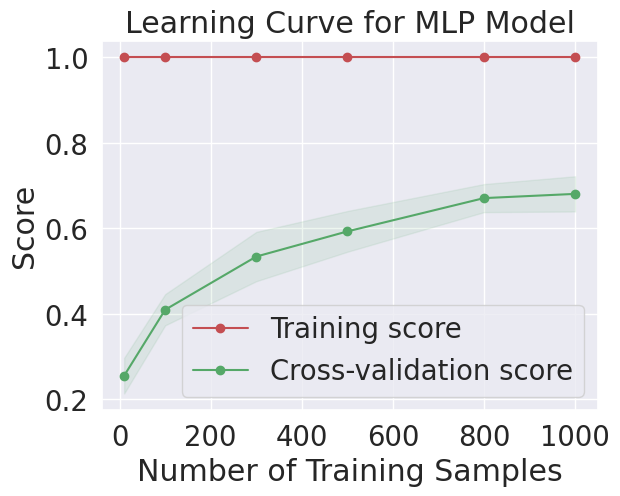

In [37]:
from sklearn.model_selection import learning_curve

# Build learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X=X_train,
    y=y_train,
    cv=10,
    shuffle=True,
    random_state=69,
    n_jobs=4,
    # We have (0.8*1440)/10 = 115/1150 training samples, 1035/1150 test samples
    train_sizes=[10,100,300,500,800, 1000] # bounded at 1035 for this dataset for 10-fold cv
)
# Get errors for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.title('Learning Curve for MLP Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()

We can find the gap between the training score curve and the cross-validation score curve shows us that the model has extremely high variance, and that it scores well on the training data but poorly on the cross-validation, Because it severely overfits the model and does not generalize the test data well at all. It is clear that this model is not the best choice for us to perform this task.